In [1]:
import SimpleITK as sitk
from subprocess import Popen
import subprocess
import SimpleITK as sitk
import pandas as pd
import multiprocessing as mp
import functools
from functools import partial
import sys
import os.path
from os import path as pathOs
import numpy as np
import tempfile
import shutil
from os.path import basename, dirname, exists, isdir, join, split
from pathlib import Path
import fileinput
import re
import subprocess
from toolz.itertoolz import groupby
import seaborn as sns
import einops
import matplotlib.pyplot as plt
import itertools
import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2
import tempfile
import shutil
import re
from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess
from skimage.segmentation import mark_boundaries
from scipy import ndimage
import torch
import xformers.components.attention.attention_patterns as AP
from xformers.components.attention.core import scaled_dot_product_attention
from xformers.components.attention._sputnik_sparse import SparseCS
import xformers.components.attention.attention_patterns as AP
%matplotlib inline
from xformers.utils import (
    generate_matching_config,
    get_registry_decorator,
    import_all_modules,
)

from pathlib import Path
from typing import Any, Callable, Dict, Set, Union

from xformers.utils import (
    generate_matching_config,
    get_registry_decorator,
    import_all_modules,
)

from xformers.components.feedforward.base import Feedforward, FeedforwardConfig  # noqa

<AxesSubplot:>

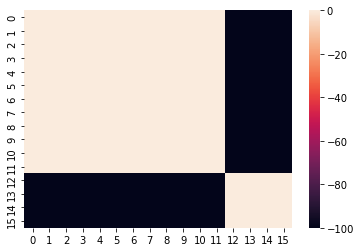

In [2]:


def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows

def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1
    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1
    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    return attn_mask

dims=(8,8)
window_size=(4,4)
shift_size=(1,1)
device='cpu'
res=compute_mask(dims, window_size, shift_size, device)
res.shape
sns.heatmap(res[2,:,:].detach().cpu().numpy())

In [ ]:
FEEDFORWARD_REGISTRY: Dict[str, Any] = {}
FEEDFORWARD_CLASS_NAMES: Set[str] = set()


def build_feedforward(config: Union[Dict[str, Any], FeedforwardConfig]):
    """Builds a feedforward from a config.

    This assumes a 'name' key in the config which is used to determine what
    attention class to instantiate. For instance, a config `{"name": "my_feedforward",
    "foo": "bar"}` will find a class that was registered as "my_feedforward"
    (see :func:`register_feedforward`) and call .from_config on it."""

    if not isinstance(config, FeedforwardConfig):
        config_instance = generate_matching_config(
            config, FEEDFORWARD_REGISTRY[config["name"]].config
        )
    else:
        config_instance = config

    return FEEDFORWARD_REGISTRY[config_instance.name].constructor.from_config(
        config_instance
    )
FEEDFORWARD_CLASS_NAMES

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


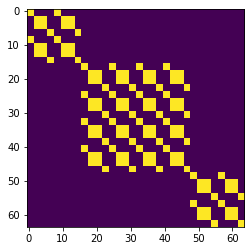

In [3]:
# generic nd cases
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)


def swin_attention_pattern(H, W, window_size, shift_size=0):
    assert H % window_size == 0
    assert W % window_size == 0
    assert 0 <= shift_size < window_size, "shift_size must in 0-window_size"

    # input grid
    i, j = _generate_nd_grid(H, W)
    i, j = i + 0.5, j + 0.5

    # anchors grid
    # if shift is present, add extra element to the grid
    # to account for the uneven partitioning
    extra = int(shift_size % window_size != 0)
    grid_h = H // window_size + extra
    grid_w = W // window_size + extra

    ii, jj = _generate_nd_grid(grid_h, grid_w)
    # convert shift to be compatible with the paper representation
    s = (-shift_size) % window_size
    offset = window_size / 2 - s
    ii = ii * window_size + offset
    jj = jj * window_size + offset

    input_coords = torch.stack([i.flatten(), j.flatten()], 1).float()
    anchors_coords = torch.stack([ii.flatten(), jj.flatten()], 1).float()

    anchor_id = torch.cdist(input_coords, anchors_coords, p=2).argmin(1)
    mask = anchor_id[:, None] == anchor_id[None, :]
    return mask

aa=swin_attention_pattern(8,8, 4, 2)
plt.imshow(aa)

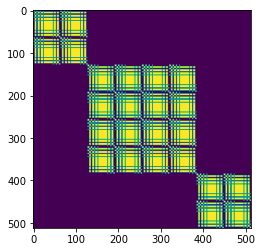

In [4]:

def swin_attention_pattern_3D(H, W,D, window_size, shift_size=0):
    assert H % window_size == 0
    assert W % window_size == 0
    assert D % window_size == 0
    assert 0 <= shift_size < window_size, "shift_size must in 0-window_size"

    # input grid
    i, j ,k = _generate_nd_grid(H, W,D)
    i, j ,k = i + 0.5, j + 0.5, k + 0.5

    # anchors grid
    # if shift is present, add extra element to the grid
    # to account for the uneven partitioning
    extra = int(shift_size % window_size != 0)
    grid_h = H // window_size + extra
    grid_w = W // window_size + extra
    grid_d = D // window_size + extra

    ii, jj ,kk= _generate_nd_grid(grid_h, grid_w,grid_d)
    # convert shift to be compatible with the paper representation
    s = (-shift_size) % window_size
    offset = window_size / 2 - s
    ii = ii * window_size + offset
    jj = jj * window_size + offset
    kk = kk * window_size + offset


    input_coords = torch.stack([i.flatten(), j.flatten(),k.flatten()], 1).float()
    anchors_coords = torch.stack([ii.flatten(), jj.flatten(),jj.flatten()], 1).float()

    anchor_id = torch.cdist(input_coords, anchors_coords, p=2).argmin(1)
    mask = anchor_id[:, None] == anchor_id[None, :]
    return mask
aa=swin_attention_pattern_3D(8,8,8, 4, 2)
plt.imshow(aa)

In [ ]:
from xformers.factory import xFormer, xFormerConfig
from xformers.helpers.hierarchical_configs import (
    BasicLayerConfig,
    get_hierarchical_configuration,
)

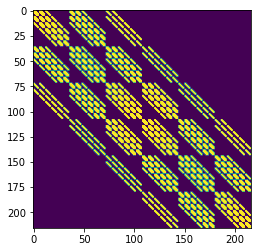

In [18]:
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)


def local_nd_distance(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    d = torch.cdist(grid, grid, p=p)
    return d

def local_nd_pattern(*sizes, distance, p=2.0):
    d = local_nd_distance(*sizes, p=p)
    # print(d)
    return d < distance


pat=local_nd_pattern(4,4,4,distance=1.5)
plt.imshow(pat)
d=local_nd_distance(6,6,6)<2.5
plt.imshow(d)

# attn_mask = SparseCS(pat, torch.device("cpu"))
# attn_mask


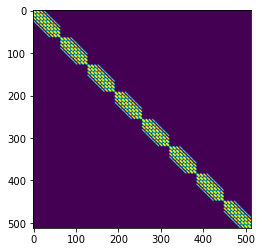

In [17]:
def local_nd_distance_with_spacing(*sizes, p=2.0, weights=None,spacing=(1.0,1.0,1.0)):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    grid[:,0]=grid[:,0]*spacing[0]
    grid[:,1]=grid[:,1]*spacing[1]
    grid[:,2]=grid[:,2]*spacing[2]
    d = torch.cdist(grid, grid, p=p)
    return d              

def local_nd_pattern_with_spacing(*sizes, distance, p=2.0,spacing=(1.0,1.0,1.0)):
    d = local_nd_distance_with_spacing(*sizes, p=p,spacing=spacing)
    # print(d)
    return d < distance

spacing=(3.299999952316284,0.78125, 0.78125)
ff=local_nd_pattern_with_spacing(8,8,8,distance=2.5,spacing=spacing)
plt.imshow(ff)

In [ ]:
        # csr_matrix = SparseCSRTensor._wrap(
        #     _shape, values, row_indices, row_offsets, column_indices, _transp_info
        # )
# SparseCSRTensor.from_dense(output)
from xformers.ops import masked_matmul
from xformers.sparse import BlockSparseTensor, SparseCSRTensor
from xformers.ops import masked_matmul
from xformers.sparse import BlockSparseTensor, SparseCSRTensor
from xformers.components.attention._sputnik_sparse import _dense_to_sparse

# SparseCSRTensor.from_dense(torch.ones(64,64))#+attn_mask
_dense_to_sparse(torch.ones(64,64),'cpu')
# attn_mask
 cls, shape, values, row_indices, row_offsets, column_indices, _transp_info

In [ ]:
from xformers.sparse import SparseCSRTensor

def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)


def local_nd_distance_parts(*sizes, p=2.0, weights=None,start=0,end=10):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    print(f"kkkk {grid.shape}")
    d = torch.cdist(grid, grid[start:end,:], p=p)
    return d

def local_nd_pattern(*sizes, distance, p=2.0,start=0,end=10):
    d = local_nd_distance_parts(*sizes, p=p
                                ,start=start
                                ,end=end)
    # print(d)
    return d < distance
part_1= SparseCS(local_nd_pattern(4,4,4,distance=1.5,start=0,end=32), torch.device("cpu"))
part_2= SparseCS(local_nd_pattern(4,4,4,distance=1.5,start=8,end=32), torch.device("cpu"))


fused=SparseCS.wrap(shape=(64,64)
              ,values= torch.cat([part_1.values,part_2.values],dim=-1)
              ,row_indices= torch.cat([part_1.row_indices,part_2.row_indices],dim=-1)
              ,row_offsets= torch.cat([part_2.row_offsets],dim=-1)#+part_1.row_offsets[-1]
              ,column_indices= torch.cat([part_1.column_indices,part_2.column_indices],dim=-1)
              ,_transp_info=(
                  torch.cat([part_1._transp_info[0],part_2._transp_info[0]],dim=-1)
                  ,torch.cat([part_1._transp_info[1],part_2._transp_info[1]],dim=-1)
                  ,torch.cat([part_1._transp_info[2],part_2._transp_info[2]],dim=-1)
                  ,torch.cat([part_1._transp_info[3],part_2._transp_info[3]],dim=-1)
                            )    )
# plt.imshow(pat)
# d=local_nd_distance(6,6,6)
# plt.imshow(d)

#torch.Size([1, 24, 24, 48, 40]) a torch.Size([1, 48, 12, 24, 20]) b  torch.Size([1, 96, 6, 12, 10])  

# attn_mask = SparseCS(pat, torch.device("cpu"))
print(f"orig {attn_mask.row_offsets}  fused {fused.row_offsets} orig {attn_mask.row_offsets.shape}  fused {fused.row_offsets.shape}  ")
torch.equal(attn_mask.row_offsets,fused.row_offsets)

In [ ]:
import einops
np.arange(3*3*3).reshape((3,3,3))

In [ ]:

# import scipy

# def _generate_nd_grid(*sizes):
#     coords = [np.arange(s) for s in sizes]
#     return np.meshgrid(*coords)

# def local_nd_distance(*sizes, p=2.0, weights=None):
#     if weights is None:
#         weights = (1,) * len(sizes)
#     assert len(sizes) == len(weights)
#     grid = _generate_nd_grid(*sizes)
#     grid = [i.flatten() * w for i, w in zip(grid, weights)]
#     grid = np.stack(grid, axis=1)#.astype(float)
#     print(grid.shape)
#     d = scipy.spatial.distance.cdist(grid, grid, 'euclidean')
#     print(d.shape)
#     return d

# def local_nd_pattern(*sizes, distance, p=2.0):
#     d = local_nd_distance(*sizes, p=p)
#     # print(d)
#     return d < distance

# # patB=local_nd_pattern(24,96,80,distance=1.5)
# patB=local_nd_pattern(12,48,40,distance=1.5)
# plt.imshow(patB)

In [ ]:
batch_size=1
img_size=(24,96,80)
# img_size=(16,16,16)
patch_size=(2,2,2)
i_layer=1
embed_dim=7

def get_image_size():
    p= patch_size
    res=[batch_size,embed_dim,img_size[0]/p[0],img_size[1]/p[1],img_size[2]/p[2]]
    for i in range(i_layer):
        res[1]=res[1]*2
        res[2]=int(res[2]//2)
        res[3]=int(res[3]//2)
        res[4]=int(res[4]//2)
    return res

get_image_size()


In [ ]:
sizes=(16,16,16)
grid = _generate_nd_grid(*sizes)
weights = (1,) * len(sizes)
grid = [i.flatten() * w for i, w in zip(grid, weights)]
grid = np.stack(grid, axis=1)#.astype(float)
grid

In [ ]:
sizes=(3,3,3)
grid = _generate_nd_grid(*sizes)
grid = [i.flatten() * w for i, w in zip(grid, weights)]
grid = torch.stack(grid, dim=1).float()
res=einops.rearrange(grid,'(x y z) p->x y z p',x=3,y=3,z=3)
# grid.shape $ torch.Size([27, 3])
res[0,2,0]

In [ ]:
from xformers.factory.model_factory import xFormer, xFormerConfig
import torch

EMB = 384
SEQ = 1024
BATCH = 16
VOCAB = 64

my_config = [
    # A list of the encoder or decoder blocks which constitute the Transformer.
    # Note that a sequence of different encoder blocks can be used, same for decoders
    {
        "reversible": False,  # Optionally make these layers reversible, to save memory
        "block_type": "encoder",
        "num_layers": 1,  # Optional, this means that this config will repeat N times
        "dim_model": EMB,
        "residual_norm_style": "pre",  # Optional, pre/post
        "position_encoding_config": {
            "name": "vocab",  # whatever position encodinhg makes sense
            "seq_len": 1024,
            "vocab_size": VOCAB,
        },
        "multi_head_config": {
            "num_heads": 4,
            "residual_dropout": 0,
            "attention": {
                "name": "linformer",  # whatever attention mechanism
                "dropout": 0,
                "causal": False,
                "seq_len": SEQ,
            },
        },
        "feedforward_config": {
            "name": "MLP",
            "dropout": 0,
            "activation": "relu",
            "hidden_layer_multiplier": 4,
        },
    },
    {
        "reversible": False,  # Optionally make these layers reversible, to save memory
        "block_type": "decoder",
        "num_layers": 3,  # Optional, this means that this config will repeat N times
        "dim_model": EMB,
        "residual_norm_style": "pre",  # Optional, pre/post
        "position_encoding_config": {
            "name": "vocab",  # whatever position encodinhg makes sense
            "seq_len": SEQ,
            "vocab_size": VOCAB,
        },
        "multi_head_config_masked": {
            "num_heads": 4,
            "residual_dropout": 0,
            "attention": {
                "name": "nystrom",  # whatever attention mechanism
                "dropout": 0,
                "causal": True,
                "seq_len": SEQ,
            },
        },
        "multi_head_config_cross": {
            "num_heads": 4,
            "residual_dropout": 0,
            "attention": {
                "name": "favor",  # whatever attention mechanism
                "dropout": 0,
                "causal": True,
                "seq_len": SEQ,
            },
        },
        "feedforward_config": {
            "name": "MLP",
            "dropout": 0,
            "activation": "relu",
            "hidden_layer_multiplier": 4,
        },
    },
]

# This part of xFormers is entirely type checked and needs a config object,
# could be changed in the future
config = xFormerConfig(my_config)
model = xFormer.from_config(config)

#  Test out with dummy inputs
x = (torch.rand((BATCH, SEQ)) * VOCAB).abs().to(torch.int)
y = model(src=x, tgt=x)
print(y)

In [ ]:
print(f"x {x.shape} y {y.shape}")

In [ ]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
import torch

BATCH = 8
SEQ = 1024
EMB = 384
VOCAB = 64

encoder_config = {
    "dim_model": EMB,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "vocab",  # whatever position encodinhg makes sense
        "seq_len": SEQ,
        "vocab_size": VOCAB,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "scaled_dot_product",#linformer",  # whatever attention mechanism
            "dropout": 0,
            "seq_len": SEQ,
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 4,
    },
}

# "constructing" the config will lead to a lot of type checking,
# which could catch some errors early on
config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((BATCH, SEQ)) * VOCAB).abs().to(torch.int)
y = encoder(x, x, x)
print(y.shape)

In [ ]:
encoder_layer = torch.nn.TransformerEncoderLayer(d_model=512, nhead=32)
src = torch.rand(10, 32, 512)
out = encoder_layer(src)
out.shape

In [ ]:
weight_decay=0.1
betas=(0.9, 0.95)
n_embd=512
block_size=128
n_layer=1
n_head=8
resid_pdrop=0.1
attn_pdrop=0.1
mlp_pdrop=0.1
attention="scaled_dot_product"
hidden_layer_multiplier=4
warmup_tokens=20
final_tokens=1000
vocab_size = 64

xformer_config = [
    {
        "reversible": False,  # Turn on to test the effect of using reversible layers
        "block_type": "encoder",
        "num_layers": n_layer,
        "dim_model": n_embd,
        "residual_norm_style": "post",
        "position_encoding_config": {
            "name": "vocab",
            "seq_len": block_size,
            "vocab_size": vocab_size,
        },
        "multi_head_config": {
            "num_heads": n_head,
            "residual_dropout": resid_pdrop,
            "use_rotary_embeddings": True,
            "attention": {
                "name": attention,
                "dropout": attn_pdrop,
                "causal": True,
                "seq_len": block_size,
                "num_rules": n_head,
            },
        },
        "feedforward_config": {
            "name": "FusedMLP",  # Use MLP if Triton is not available
            "dropout": mlp_pdrop,
            "activation": "gelu",
            "hidden_layer_multiplier": hidden_layer_multiplier,
        },
    }
]

config = xFormerConfig(xformer_config)
config.weight_init = "small"
model = xFormer.from_config(config)
model(torch.ones(10,vocab_size,n_embd).int())

In [ ]:
from collections.abc import Sequence
import torch.nn as nn
from monai.networks.layers import DropPath, trunc_normal_

class Relative_position_embedding_3d(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        curr_img_size: Sequence[int],
    ) -> None:


        super().__init__()
        self.dim = dim
        self.curr_img_size = (int(curr_img_size[0]),int(curr_img_size[1]),int(curr_img_size[2]))
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__
        
        if len(self.curr_img_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.curr_img_size[0] - 1) * (2 * self.curr_img_size[1] - 1) * (2 * self.curr_img_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.curr_img_size[0])
            coords_h = torch.arange(self.curr_img_size[1])
            coords_w = torch.arange(self.curr_img_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.curr_img_size[0] - 1
            relative_coords[:, :, 1] += self.curr_img_size[1] - 1
            relative_coords[:, :, 2] += self.curr_img_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.curr_img_size[1] - 1) * (2 * self.curr_img_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.curr_img_size[2] - 1
        elif len(self.curr_img_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * curr_img_size[0] - 1) * (2 * curr_img_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.curr_img_size[0])
            coords_w = torch.arange(self.curr_img_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.curr_img_size[0] - 1
            relative_coords[:, :, 1] += self.curr_img_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.curr_img_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        print(f"rrrrrrrr relative_position_bias_table \n{self.relative_position_bias_table}")
        sns.heatmap(self.relative_position_bias_table.detach().cpu().numpy())

    def forward(self, attn,n):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)  # type: ignore
        ].reshape(n, n, -1)
        print(f"relative_position_bias {relative_position_bias.shape}")
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        return attn

In [ ]:

attn=Relative_position_embedding_3d(2,2,(4,4,4))

In [ ]:
import torch 

def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)

def local_nd_distance(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    print(f"ggg \n {grid} \n")

    d = torch.cdist(grid, grid, p=p)
    return d

local_nd_distance(2,2,2)

In [ ]:
import torch 

spacing=(0.5,0.5,2.0)

def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)

def local_nd_distance_with_spacing(*sizes, p=2.0, weights=None,spacing=spacing):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    grid[:,0]=grid[:,0]*spacing[0]
    grid[:,1]=grid[:,1]*spacing[1]
    grid[:,2]=grid[:,2]*spacing[2]
    print(f"ggg \n {grid} \n")

    d = torch.cdist(grid, grid, p=p)
    return d

local_nd_distance(2,2,2,spacing=spacing)

In [2]:
import h5py
h5_path="/workspaces/konwersjaJsonData/explore/hdf5_loc/sparse_masks"

f = h5py.File(h5_path,'r+')

In [9]:
# f.close()
# f["32_32_32/dist_8_spacing_0.78125_0.78125_3.299999952316284/non_iso_vol"].keys()
# f["32_32_32/swin/window_4/main"].keys()
# f["32_32_32/dist_8/iso_vol"].keys()

f["32_32_32/swin/window_4/main"].keys()

<KeysViewHDF5 ['0_transp_info', '1_transp_info', '2_transp_info', '3_transp_info', 'column_indices', 'row_indices', 'row_offsets', 'shape', 'values']>

In [60]:
f.close()

In [57]:
from xformers.sparse import BlockSparseTensor, SparseCSRTensor
import xformers

group_to_load=f["32_32_32/dist_8/iso_vol"]
keys=list(group_to_load.keys())
transp_info_keys= list(filter(lambda el: 'transp_info' in el  ,keys))

# transp_info_keys

values=torch.tensor(group_to_load['values'][()])
shape=tuple(group_to_load['shape'][()])
# shape=(values.shape[0],) + shape

# attn_mask = SparseCSRTensor._wrap((values.shape[0],) + shape
attn_mask = xformers.components.attention._sputnik_sparse.SparseCS.wrap(shape=shape
, values= values
, row_indices= torch.tensor(group_to_load['row_indices'][()]).type(torch.int32)
, row_offsets= torch.tensor(group_to_load['row_offsets'][()]).type(torch.int32)
, column_indices= torch.tensor(group_to_load['column_indices'][()]).type(torch.int32)
, _transp_info=(torch.tensor(group_to_load['0_transp_info'][()]).type(torch.int32)
                ,torch.tensor(group_to_load['1_transp_info'][()]).type(torch.int32)
                ,torch.tensor(group_to_load['2_transp_info'][()]).type(torch.int32)
                ,torch.tensor(group_to_load['3_transp_info'][()]).type(torch.int32)
                )
)

In [58]:
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)

def local_nd_distance(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    d = torch.cdist(grid, grid, p=p)
    return d

def local_nd_pattern(*sizes, distance, p=2.0):
    d = local_nd_distance(*sizes, p=p)
    # print(d)
    return d < distance

# aaaa (32.0, 32.0, 32.0) distance 8
local_mask=local_nd_pattern(32,32,32,distance=8)
local_mask = SparseCS(local_mask, torch.device("cpu"))

In [56]:
# torch.equal(attn_mask.row_indices,local_mask.row_indices)
type(attn_mask)
attn_mask.shape

torch.Size([32768, 32768])

In [55]:
local_mask.shape

torch.Size([32768, 32768])

In [59]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
from xformers.factory.model_factory import xFormer, xFormerConfig
from xformers.components import MultiHeadDispatch, build_attention
from xformers.sparse import BlockSparseTensor, SparseCSRTensor

from xformers.components.feedforward.fused_mlp import FusedMLP

DROPOUT=0.0

SEQ=32768
EMB= 12
num_heads=2
my_config = {
    "name": "scaled_dot_product",  # you can easily make this dependent on a file, sweep,..
    "dropout": DROPOUT,
    "seq_len": SEQ,
    "attention_query_mask": None#torch.rand((SEQ, 1)) < 0.3, # some dummy mask
}
# attention = xops.memory_efficient_attention

attention=build_attention(my_config)

# build a multi head dispatch to test this attention mechanism
multi_head = MultiHeadDispatch(
    seq_len=SEQ,
    dim_model=EMB,
    residual_dropout=DROPOUT,
    num_heads=num_heads,
    attention=attention,
)
q=torch.rand((2,SEQ,EMB))
k=torch.rand((2,SEQ,EMB))
v=torch.rand((2,SEQ,EMB))

# attention(q,k,v,att_mask=attn_mask)#,att_mask=attn_mask
attention(q,k,v,att_mask=attn_mask)#,att_mask=attn_mask

tensor([[[0.5055, 0.5182, 0.5027,  ..., 0.4969, 0.5157, 0.5013],
         [0.5041, 0.5215, 0.5003,  ..., 0.5046, 0.5138, 0.4912],
         [0.5061, 0.5255, 0.5051,  ..., 0.4999, 0.5056, 0.4848],
         ...,
         [0.4872, 0.5290, 0.4844,  ..., 0.5216, 0.4983, 0.4949],
         [0.4849, 0.5235, 0.4821,  ..., 0.5160, 0.4978, 0.4946],
         [0.4909, 0.5128, 0.4824,  ..., 0.5163, 0.5119, 0.4969]],

        [[0.4823, 0.4939, 0.5164,  ..., 0.4930, 0.4992, 0.4844],
         [0.4717, 0.4972, 0.5296,  ..., 0.4877, 0.4997, 0.4947],
         [0.4736, 0.5009, 0.5257,  ..., 0.4865, 0.5004, 0.4903],
         ...,
         [0.4997, 0.4825, 0.4790,  ..., 0.5088, 0.5033, 0.4953],
         [0.4906, 0.4845, 0.4810,  ..., 0.5077, 0.5130, 0.5011],
         [0.4935, 0.4770, 0.4709,  ..., 0.5123, 0.5136, 0.4991]]])

In [16]:
import torch 
import torch.nn as nn

from xformers.components.attention.core import _matmul_with_mask
mask= torch.zeros((4,4))
q= torch.ones((4,4))
k= torch.eye(4)
att = _matmul_with_mask(q, k.transpose(-2, -1), mask)
att

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [46]:
import torch
import einops
bb=torch.zeros((3,3)).bool()
bb[1,1]=True
bb[0,1]=True
bb[1,2]=True
cc= torch.ones((3,3))*2
cc[1,1]=3
indicies=torch.argwhere(bb)
indicies=einops.rearrange(indicies,'a b -> b a')

spp=torch.sparse_coo_tensor(indices=indicies, values=cc[bb])
# spp

# spp.coalesce().values()
new_matrix = torch.stack([matrix for _ in range(4)], dim=0)

NotImplementedError: Could not run 'aten::as_strided' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::as_strided' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:31034 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:43986 [kernel]
Meta: registered at aten/src/ATen/RegisterMeta.cpp:26824 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:929 [kernel]
QuantizedCUDA: registered at aten/src/ATen/RegisterQuantizedCUDA.cpp:459 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at aten/src/ATen/RegisterFunctionalization_0.cpp:20475 [kernel]
Named: fallthrough registered at ../aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: fallthrough registered at ../aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at ../aten/src/ATen/native/NegateFallback.cpp:23 [kernel]
ZeroTensor: registered at aten/src/ATen/RegisterZeroTensor.cpp:161 [kernel]
ADInplaceOrView: registered at ../torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4733 [kernel]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:15232 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_0.cpp:16728 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:487 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:819 [kernel]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1077 [kernel]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:148 [backend fallback]


In [15]:
i = torch.tensor([[0, 1, 1],
                   [2, 0, 2]])
v = torch.tensor([3, 4, 5], dtype=torch.float32)
torch.sparse_coo_tensor(i, v, [2, 4])

tensor(indices=tensor([[0, 1, 1],
                       [2, 0, 2]]),
       values=tensor([3., 4., 5.]),
       size=(2, 4), nnz=3, layout=torch.sparse_coo)

In [66]:
import pandas as pd
df=pd.read_csv("/workspaces/konwersjaJsonData/CRF.csv")
df=df[['patient_id','dre_result','patient_age','psa_result']].replace("Dodatni (+)", "1.0")
df=df[['patient_id','dre_result','patient_age','psa_result']].replace("Ujemny (-)", "0.0")
df['dre_result']=pd.to_numeric(df['dre_result'])
df['dre_result']=np.nan_to_num(df['dre_result'].to_numpy(),-1.0)
df['dre_result'].to_numpy()

array([1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0.

In [51]:
df.columns

Index(['_id', 'clinical_group', 'cribriform', 'dre_result', 'eau_risk',
       'gs_primary', 'gs_secondary', 'gs_total', 'is_cancer', 'isup_group',
       'last_modified_date', 'lesion_samples_occupied_length',
       'lesion_samples_occupied_number', 'lesion_samples_taken_length',
       'lesion_samples_taken_number', 'mri_source', 'patient_age',
       'patient_id', 'postoperative_margin', 'prior_biopsies',
       'prostate_volume_mri', 'prostate_volume_us', 'psa_density_mri',
       'psa_density_us', 'psa_result', 'samples_occupied_length_l',
       'samples_occupied_length_r', 'samples_occupied_number_l',
       'samples_occupied_number_r', 'samples_taken_length_l',
       'samples_taken_length_r', 'samples_taken_number_l',
       'samples_taken_number_r', 'tnm_clinical_t',
       'tnm_pathological_postoperative_m', 'tnm_pathological_postoperative_n',
       'tnm_pathological_postoperative_t', 'tnm_pathological_t', 'treatment'],
      dtype='object')

In [72]:
from xformers.components.feedforward.fused_mlp import FusedMLP
import torch.nn as nn


dim=20
inputt=torch.ones((1,3))
dense = nn.Linear(3,dim)

mlp=FusedMLP(dim_model=dim,activation ="gelu",hidden_layer_multiplier=1,dropout=0.05)
mlp(dense(inputt)).shape


torch.Size([1, 20])

In [35]:
import torch
import einops
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)

def local_nd_distance(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    d = torch.cdist(grid, grid, p=p)#,compute_mode="donot_use_mm_for_euclid_dist"
    # d=cdist2(grid, grid)
    return d

ref=local_nd_distance(8,8,8)




def local_nd_distance_my(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    # x=einops.rearrange(x, '(bb a) b -> bb a b', bb=4)
    # y=einops.rearrange(y, '(bb a) b -> bb a b',bb=4)
    
    # d=torch.nn.functional.pairwise_distance(x,y)
    
    # d=einops.rearrange()
    # d=cdist2(grid, grid)
    for_div=4
    div= grid.shape[0]//for_div
    d=list(map(lambda i : torch.cdist(grid, grid[div*i:div*(i+1),:], p=p), range(for_div-1)))
    d.append( torch.cdist(grid, grid[div*(for_div-1):,:]))

    return torch.cat(d,dim=1)

my=local_nd_distance_my(2,2,2)
boool=my<1.1
# print(f"mmm my {my.shape} \n {my}  ")

# print(f"eeeeeee {torch.equal(ref,my)}")


        # local_mask = loc_dists>distance
        # indicies=torch.argwhere(local_mask)


torch.equal(aa,sorted)
aa= torch.argwhere(boool)
aa

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 4],
        [1, 0],
        [1, 1],
        [1, 3],
        [1, 5],
        [2, 0],
        [2, 2],
        [2, 3],
        [2, 6],
        [3, 1],
        [3, 2],
        [3, 3],
        [3, 7],
        [4, 0],
        [4, 4],
        [4, 5],
        [4, 6],
        [5, 1],
        [5, 4],
        [5, 5],
        [5, 7],
        [6, 2],
        [6, 4],
        [6, 6],
        [6, 7],
        [7, 3],
        [7, 5],
        [7, 6],
        [7, 7]])

In [43]:
def loc_arg_where(i,boool):
    res= torch.argwhere(boool[i:i+1,:])
    res=res+torch.tensor([i,0])
    return res

bb=list(map( lambda i :  loc_arg_where(i,boool),range(bb.shape[0])))
bb= torch.cat(bb,dim=0)
torch.equal(aa,bb)
# bb=torch.argwhere(boool[0:1,:])
# bb


True

In [53]:
window_size=(2,2,2)
num_heads=3
coords_d = torch.arange(window_size[0])
coords_h = torch.arange(window_size[1])
coords_w = torch.arange(window_size[2])

coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
coords_flatten = torch.flatten(coords, 1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
relative_coords = relative_coords.permute(1, 2, 0).contiguous()
relative_coords[:, :, 0] += window_size[0] - 1
relative_coords[:, :, 1] += window_size[1] - 1
relative_coords[:, :, 2] += window_size[2] - 1
relative_coords[:, :, 0] *= (2 * window_size[1] - 1) * (2 * window_size[2] - 1)
relative_coords[:, :, 1] *= 2 * window_size[2] - 1

relative_position_index = relative_coords.sum(-1)
relative_position_index 

relative_position_bias_table=torch.zeros(
                    (2 * window_size[0] - 1) * (2 * window_size[1] - 1) * (2 * window_size[2] - 1),
                    num_heads,
                )

relative_position_bias_table

n=4
relative_position_bias=relative_position_bias_table[
            relative_position_index.clone()[:n, :n].reshape(-1)  # type: ignore
        ].reshape(n, n, -1)
relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
relative_position_bias

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [5]:
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)

def local_nd_distance(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    d = torch.cdist(grid, grid, p=p)
    return d

loc_dists=local_nd_distance(4,4,4)
distance=1.5
loc_dists= einops.rearrange(loc_dists,'a b -> 1 a b')
local_mask = loc_dists<distance
indicies=torch.argwhere(local_mask)
indicies=einops.rearrange(indicies,'a b -> b a')
sparse_loc_dist= torch.sparse_coo_tensor(indicies, values=loc_dists[local_mask])

sparse_loc_dist.to_dense()

tensor([[[0.0000, 0.0000, 2.0000,  ..., 4.3589, 4.6904, 5.1962],
         [0.0000, 0.0000, 0.0000,  ..., 4.2426, 4.3589, 4.6904],
         [2.0000, 0.0000, 0.0000,  ..., 4.3589, 4.2426, 4.3589],
         ...,
         [4.3589, 4.2426, 4.3589,  ..., 0.0000, 0.0000, 2.0000],
         [4.6904, 4.3589, 4.2426,  ..., 0.0000, 0.0000, 0.0000],
         [5.1962, 4.6904, 4.3589,  ..., 2.0000, 0.0000, 0.0000]]])

In [6]:
loc_dists

tensor([[[0.0000, 1.0000, 2.0000,  ..., 4.3589, 4.6904, 5.1962],
         [1.0000, 0.0000, 1.0000,  ..., 4.2426, 4.3589, 4.6904],
         [2.0000, 1.0000, 0.0000,  ..., 4.3589, 4.2426, 4.3589],
         ...,
         [4.3589, 4.2426, 4.3589,  ..., 0.0000, 1.0000, 2.0000],
         [4.6904, 4.3589, 4.2426,  ..., 1.0000, 0.0000, 1.0000],
         [5.1962, 4.6904, 4.3589,  ..., 2.0000, 1.0000, 0.0000]]])

In [7]:
import torch
from x_transformers import TransformerWrapper, Encoder,ContinuousTransformerWrapper

model = ContinuousTransformerWrapper(
    num_tokens = 20000,
    max_seq_len = 1024,
    use_abs_pos_emb = False,
    attn_layers = Encoder(
        dim = 512,
        depth = 12,
        heads = 8
    )
).cuda()

x = torch.rand((1, 1024)).cuda()
# x = torch.randint(0, 256, (1, 1024)).cuda()
mask = torch.ones_like(x).bool()

model(x, mask = mask) # (1, 1024, 20000)

TypeError: ContinuousTransformerWrapper.__init__() got an unexpected keyword argument 'num_tokens'

In [13]:
import torch
from x_transformers import ContinuousTransformerWrapper, Decoder
from x_transformers import ContinuousAutoregressiveWrapper

model = ContinuousTransformerWrapper(
    dim_in = 24,
    dim_out = 24,
    max_seq_len = 1024,
    attn_layers = Encoder(
        dim = 512,
        depth = 12,
        heads = 8
    )
)

# wrap it with the continuous autoregressive wrapper

# model = ContinuousAutoregressiveWrapper(model)

# mock data

x = torch.randn((1, 24, 24))
aaa=model(x)
aaa.shape
# mask = torch.ones(1, 1024).bool()

# # train on a lot of data above

# loss = model(x, mask = mask)
# loss.backward

# # # then generate

# start_emb = torch.randn(1, 777)
# generated = model.generate(start_emb, 17) # (17, 777)

torch.Size([1, 24, 24])

In [20]:
def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows

window_partition(torch.ones(2,32,32,32,1),(4,4,4)).shape

torch.Size([1024, 64, 1])

In [21]:
(32*32*32*2)/(4*4*4)

1024.0